In [13]:
from glob import glob
import os
from itertools import combinations

from tqdm import tqdm
import pandas as pd

In [14]:
sigles = [os.path.basename(fn).replace('xml_', '').replace('.xml', '') for fn in glob('../data/xml_martijn/*.xml')]
sigles = sorted(sigles)
sigles

['A',
 'Ant',
 'B',
 'BR',
 'C',
 'D',
 'D2',
 'E',
 'F',
 'Ge',
 'K',
 'L',
 'O',
 'W',
 'Y',
 'Z']

In [15]:
sigles = 'A', 'B', 'F'

In [16]:
from lxml import etree

NSMAP = {'MVN': 'http://www.tei-c.org/ns/1.0'}
removes = ('teiHeader', 'fw', 'supplied', 'abbr') 

def extract_lines(xml_file):
    lines = {}
    tree = etree.parse(xml_file)
    etree.strip_elements(tree, ("{"+ NSMAP["MVN"]+ "}" + s for s in removes), with_tail=False)
    for text_node in tree.iterfind('//MVN:text', namespaces=NSMAP):
        try:
            title = text_node.attrib['n']
        except KeyError:
            continue
        for line_node in text_node.iterfind('.//MVN:l', namespaces=NSMAP):
            k = title + '-' + line_node.attrib['n']
            line_text = ''.join(line_node.itertext()).lower()
            line_text = ' '.join(line_text.strip().split())
            lines[k] = line_text
    return lines

In [17]:
d = extract_lines(f'../data/xml_martijn/xml_{sigles[0]}.xml')

In [18]:
mss = {}

for sigle in tqdm(sigles):
    mss[sigle] = extract_lines(f'../data/xml_martijn/xml_{sigle}.xml')

100%|██████████| 3/3 [00:00<00:00, 31.23it/s]


In [19]:
print(mss.keys())

dict_keys(['A', 'B', 'F'])


In [20]:
import numpy as np

# from: https://gist.github.com/slowkow/06c6dba9180d013dfd82bec217d22eb5

def nw(x, y, match = 1, mismatch = 1, gap = 1):
    nx = len(x)
    ny = len(y)
    # Optimal score at each possible pair of characters.
    F = np.zeros((nx + 1, ny + 1))
    F[:,0] = np.linspace(0, -nx, nx + 1)
    F[0,:] = np.linspace(0, -ny, ny + 1)
    # Pointers to trace through an optimal aligment.
    P = np.zeros((nx + 1, ny + 1))
    P[:,0] = 3
    P[0,:] = 4
    # Temporary scores.
    t = np.zeros(3)
    for i in range(nx):
        for j in range(ny):
            if x[i] == y[j]:
                t[0] = F[i,j] + match
            else:
                t[0] = F[i,j] - mismatch
            t[1] = F[i,j+1] - gap
            t[2] = F[i+1,j] - gap
            tmax = np.max(t)
            F[i+1,j+1] = tmax
            if t[0] == tmax:
                P[i+1,j+1] += 2
            if t[1] == tmax:
                P[i+1,j+1] += 3
            if t[2] == tmax:
                P[i+1,j+1] += 4
    # Trace through an optimal alignment.
    i = nx
    j = ny
    rx = []
    ry = []
    while i > 0 or j > 0:
        if P[i,j] in [2, 5, 6, 9]:
            rx.append(x[i-1])
            ry.append(y[j-1])
            i -= 1
            j -= 1
        elif P[i,j] in [3, 5, 7, 9]:
            rx.append(x[i-1])
            ry.append('-')
            i -= 1
        elif P[i,j] in [4, 6, 7, 9]:
            rx.append('-')
            ry.append(y[j-1])
            j -= 1
    # Reverse the strings.
    rx = ''.join(rx)[::-1]
    ry = ''.join(ry)[::-1]
    return rx, ry

In [21]:
distances = []

for ms1, ms2 in tqdm(list(combinations(mss.keys(), 2))):
    common_idxs = set(mss[ms1].keys()).intersection(set(mss[ms2].keys()))
    for idx in common_idxs:
        line1, line2 = mss[ms1][idx], mss[ms2][idx]
        print('=================')
        rx, ry = nw(line1, line2)
        assert len(rx) == len(ry)
        print('\n'.join([rx, ry]))
        length = len(rx)
        for idx, (a, b) in enumerate(zip(rx, ry)):
            if a != b:
                distances.append((ms1, ms2, idx/length, 1))
            else:
                distances.append((ms1, ms2, idx/length, 0))

  0%|          | 0/3 [00:00<?, ?it/s]

te ke-n-ne hem dien wi vleen
te kennene hem dien wi vleen
wie was die eerst---- minne vant
wie was die eerst die minne vant
dat aermoede es een pat
die a-rmoede es een pat
den vader in die godheit
den vader in die godheit
torment-eren ende vaen
tormentieren ende vaen
daer af --tellen alle wo-rt
dair of spre-ken alle woirt
hi dinct mi mesdoen in dien
hi dinct mi mesdoen in dien
spreect heuestu gheen spreken in
spr-ec- he-bstu gheen spreken jn
dat in dietsch- luudt minne
dat in dietsche luu-t minne
ende l-eghet hem met wraken naer
ende leech-t hem met wraken naer
ende brieuen die ghewaghen das
ende brieuen die ghewaghen das
met do-gheden besne-den
mit douch-den besneiden
licht-re ware dan een zant
lichter- ware dan een zant
buten des -viants roede
buten der duuelen roede
hem--- can ghehelpen el gheen cruut
hem en can ghehelpen--- ander cruut
iacop ma-c mi gheen ghescal
jacop maec mi gheen g-escal
wie saelt -ouer recht curen
wie sa-l- vo-ir recht curen
iacop dijn vraghen es swaer
iacop di

mi-jn ban ende si ne sulne of wriuen
ende moet- mine zinne- dwaen
ende moete mine zinnen dwaen
die zielen int helsche dal
die zielen int helsche dal
die vanden wat-re maecte wijn
die va---n water- maicte wijn
onder der duuele- roeden
onder der duuelen roede-
eere d-er ker-ken ente---n outaer
eere die- kercke- ende die outair
ende hem naersus heuet -versm-ort
ende --m---e-dea dede- die- moort
hine- darf beiden nochte haken
hi en darf beiden no---- haken
in weeter wat toe segghen el
en w-eter wat toe segghen el
sine wijsheit es coninghinne
sine wijshede es coning-inne
dat behoet hi ende besat
dat behoet hi ende besat
rudderscap wesen verwoet
ridderscap wesen verwoet
den vader bidt vor sine caren
den vader----- vor sine caren
waenstu dat mi wel behaghet
waenstu dat mi wel behaghet
eewelike sonder versceet
-ewelike sonder versceet
tontijt waerstu gheboren
tontijt waerstu gheboren
si slachten den wine- en---ter gloet
si slachten den winen ende der gloet
ieghen---- reenre minnen lecht
jeghen

die sine vorme spieghelt ende siet
entie hare volghe-t ---es ghescent
--die hare volghede ware- ghescent
dit doet vrouwen beniden
dit doet vrouwen beniden
ten joncsten------ we-sen gram
ten jonxsten daghe werden gram
du gheues den mannen al de scout
-------------------------------ø
ende versmo-rde sulken pant
end- versmoirde sulken pant
wi-l--men emmer vulbringhen
wille men emmer volbringhen
ieghen- des duuels brant
jeghens des duuels brant
daer bliuet hi altoes inne
dair bliuet hi altois jnne
dat hem god hoyr beriede
dat hem god -oyt beriede
daer ne- -es toe- -recht toe gheen doen
dair nes ie--ghen crach--t-- gheen doen
so rust--e in die- maghet smale
---rustede in-d-er maghet smale
nu spreect ende ic ghedoghe
nu spreect ende ic ghedoghe
die cnoep die alexander bant
die knoop die alexander vant
deerste minne es so groot
deerste minne es so groot
die do-r mi lust beuen
die doir mi lust leuen
mijn meester als ict kinne
mijn meester als ic- kinne
wart- mensche- tonser bederue
---te -ons-

dair bi ontsteict dat droghe
al waert dat alle di---ng--le- quamen
al wairt dat alle die enghelen quamen
want hem sijns vader vlouc mesquam
want hem ----s-vader vlouc mesquam
subtijl wa-re therte diet bevinghe
subtijl wair- tharte diet bevinghe
ende sulc ---es slands verdreuen
ende zulc zijns -lants verdreuen
alle die he-leghe liede
alle die heilighe liede
ende nutter eist dat hi vliet de- naen
-----nutter -is- dat hi vlie- den -aen
ende ghedoghede gr-ote coude
ende ghedoghede groot- coude
-ennes niet erghers bleuen
het is niet argher- bleuen
marien dat ontboot
marien dat ontboot
dit euel te- beghinne
dit euel ten beghinne
hine- caens niet gheliden
hi en ca-nt niet gheliden
ende verslouch haren broeder
ende verslouch haren broeder
te ---sacre-erne in priesters hande
te consacrere-n- in priesters hande
du best der weerelt scame
du best der w-erelt scame
alle dorperhe-de
alle dorperheide
daer hi -eewelijc es ghe-scent
dair hi nemme--rmeer --en went
ic wa-en mer also vele vint
ic wane- me

mit hem ne- twifel-ts twint
god moet in hem seluen sijn
god moet in hem seluen zijn
hi gheue-t ons ziele vleesch ende bloet
hi ghe-eft ons ziele vleesch ende bloet
en---tie alre cortste vaert
ende die alre cortste vaert
ne da----de dat- lief w-orde leit
ne wair ooc dat. lief wair-- leit
den loen ha-re weder gheuen
den loon hair- weder gheuen
dese god daer wi af leeren
dese god dair wi of l-eren
ende mi eene andere so heue-t jn
ende mi -ene and-re so he-eft jn
die ons benam dat helsche cout
die ons benam dat helsche cout
-ic zwerdi- dat bi marien
des --hopic -a---n marien
want al dat gheslachte sijn
want--- dat gheslachte zijn
men machene niet verblenden
men machen- niet verblenden
of mi die stroem met----ter spoet
of mi d-e stroom mit groter spoet
ic bems te beterne ghereit
jc bens te beter-- ghereit
dat wi dus sijn versceeden
dat wi dus zijn versc-eden
dies ghelijcs willic ghereet
d-es ghelijcs wil ic ghereet
hout in een w-ort sin----n-e bespiet
hout--- -j. woort -jn d ende bespiet
de

vrouwe coninghinne
vrouwe coning-inne
hine es sijns selues niet eyghijn
--n--es zijns selues niet e-ghijn
inden joncsten male
inden laetsten male
heden ghist-er e--s onse leuen
huden ghistre- ende onse leuen
ende late- tgheloue niet te storen
ende latet -gheloue niet te storen
man te verheffene bouen man
man te verheffen- bouen man
marti-n hier bi moghestu sien
martijn hier bi moghestu zien
als men gheen mesdoen -ne spaert
als-men gheen mesdoen en- spairt
hi es die der propheten sinne
hi es di---e- propheten zinne
-----int gh-emeene ende hem ontfaen
gaen int gheemeen- ende hem ontfaen
waerstu een dorp-- du spraex van -coen-
wairstu een dorper du spraex van «koen»
al sou-t al varen inder vaert
al soudt al varen inder vaert
die sinen sin so laet versteenen
die sinen sin so laet verst-enen
brincstu ongheloue vort
brincstu ongheloue vort
hore wat scrifture mi gaf
hore wat scrifture mi gaf
te- hemele waert ende so glat
ten hemel- wairt ende so glat
soe liete ha-re eer--- ----be--douwen
soe 

dat wien so vrauwen minne ontspoen
hets ghetrouwe als eene zie
te-s ghetrauwe als -die zie
minres in trouwen ghehint
minres in trauwen ghehint
dat es tedelste delijt
dat--s tedelste delijt
in siere herten binnen
jn zi-jn harte- binnen
nu es mijn herte so hart .i. vlint
nu es mijn harte so hart -j. blint
die mi therte do-r b-orde
die mi tharte doir boorde
dan ic-- viel- in dommen waen
dan ic u viele in dommen waen
so wille hi sonder merre
hi wille--- sonder merre
hi ware eewelike verdoemt
hi ware -ewelike verdo-mt
doe wel alto----es ende ontsprinc
do---e- altois wel ende ----dwing
biddic dat hi den duuel
biddic dat hi den duuel
------dompelike toe tiden
diere dom-mlike toe tiden
ende niet scelden den heere
ende niet scelden den h-ere
dat deen den andren vermo-rt
dat deen den andren vermoirt
alse hi hem daer ane -echt
als- hi hem dair ane hecht
al gau--ic wech lijf ende scat
al gaue ic wech goet ende scat
sin----t edelheit hadde vaer
sint dat edelheit hadde vaer
wie was van minnen oint g

euen ghelijc in werelt in throne
vanden ---ouden viant
vanden helschen viant
wie mochte els bringhen inder no-ot
wie mochte els bringhen inde- no#ot
hennes wijsheit niet dinne
he-n-s wijsheit niet dinne
iane trac so theme-sche broot
jane trac so themelsche broot
ende bouen al gheual
ende bouen al gheual
dicken wint dongaue lam
dicken wint tongaue lam
berecht een god die noyt -en wies
berecht een god die noyt ne- wies
die gods sone toghet ons dat
die gods sone toghet ons dat
dat si hem dat herte ontien
dat si hem dat herte ontyen
wie mach we-ten sinen staet
wie mach weiten sinen -raet
daer hi cume---- soghes was sat
dair hi cume oyt zoghes was zat
dese twee sijn in een bewant
dese tw-e zijn in een bewant
ende nv es ghemanc
ende nv es g-emanc
iacop dune- souds di niet vergramen
iacop du en zouts di niet vergramen
om eere om goet staet al haer gaer
om -ere om goet staet--- hair gaer
dit verlies sonder ghetal
dit verlies sonder g-etal
niet en hebbe gheho-rt
niet en he-b- ghehoirt
dupperste

dat die guede fl-eu--t ende bidt
pays ende vrede bleue fijn
pays ende vrede bleue fijn
die godheit diet al bint
die godheit diet al bint
berechten dat--- te vullen doghe
berechten dat di te vullen doghe
alse een prinche verwan wijch vp tvelt
als- een prinche ---wan wijch op tvelt
van-----der edelhe-den
van rechter edelheiden
dat ic mi eer ver-mo-rde
dat ic mi eer versmoirde
natuere -ne wils niet ghehinghen
natu-re en- wils----- ghehinghen
hens coninc noch coninghinne
hens coninc no-- coning-inne
dattu helts ant le-gher bo-rt
dattu helts an- leggher boirt
450 die ne-m--m-er af laet ghewinne
----die -emmermeer of laet ghewinne
en---tie redene bevinde
ende die redene beuinde
du pl-eghes dies rude-- liede- plien
du pleech-s d-at rude p lieden plien
ende wat die hemel heeft ane
ende wat d-e hemel heeft ane
of mijn verstaen es dinne
of mijn verstaen es dinne
ende volghen har----e -al ware so ghevloen
ende volghen hare die hem ware -o--ntfloen
alse diese ouer vo-ghet helt
als- diese ouer voeg

al gheheel ende alte male
al gheheel ende alte male
hi es buten al nv mer-ke
hi es buten al nv mercke
he-b-di- --mi dat hu god lone
hebbe ic bedi dat di god lone
dat -hi-et hi verdoemen
dat deide- hi verdo-men
dincti dese redene blent
dincti dese redene blent
maer het was mi te vindene zwaer
m-er het was mi te vinden- zwair
ende ghewijst ende gheleert
ende ghewijst ende gheleert
be-re-----cht mi ia of neen
-ende antwert mi ja of neen
ontfaerm-cheit van moede
ontfa-rmicheit van moede
end-e dor -on-s sijn bloet root
--die der minen zijn bloet root
altoes leuen ende onghehent
altois leuen ende onghe-ent
van gheveinsder spraken
van ghepeynsden s--aken
soude men verdriuen
soude-men verdriuen
beede vp berch ende vp dal
b-ede op ber-g ende in dal
die alre gauen es meest
die alre hauen es meest
dat nemmermeer vergheet
dat nemmermeer te gheet
nu bene-me-t dat venijn
nu beneyment dat venijn
vanden e-delen abraham
vanden eydelen abraham
begonste in hemelri-ke
begon-de in hemelrijke
wel hem diere 

ne- was noyt mi-t sonden begoort
------lucht water ende lant
water luch----t-- ende lant
omme al te hebbene alleene
omme al te hebben- all-ene
----dat hi daer toe taelde
van dat hi dair toe taelde
dat eewelike steet
dat -ewelike steet
in sine godlicheit
in sine godlicheit
sijn wesen es als ict --kinne
sijn wesen es als ict bekinne
dit hebbic onder vonden
dit hebbic onder-uonden
niemen dorst---em----- vermoeden
hi-ne- dorste hem niet vermoeden
alle sinne- sijn te droghe
alle zinnen zijn te droghe
heue-t dit saen ontbonden
he-eft dit zaen ontbonden
met godliken goede
mit godliken goede
soe staerf dus eist becant
so- sta-rf dus e-st becant
panden van haren ponden
panden van --den ponden
iacop menech prouft ende coort
iacop menich prouft ende coort
dattu mi heues verbeent
dattu mi he-bs verbeent
dat nemmermee- mach werden sat
dat nemmermeer mach --zijn zat
den vader in sijn ri-ke
den vader in--den rijke
meerre moert da-n- sonden
meerre mo-rt danne zonden
die blo-yende jare
die bloeyende ja

dat si- sijn met minne--n --verplecht
ende gheuen der eeren eenen ban
ende gheuen der -eren -enen ban
ofte in heresien
of-- in heresien
prouf dattu wilt jacop ende les
prouf dattu wils iacop ende les
wien maecte oint minn---e blent
wien maicte di-e minne ye blint
entie redene tontmoetene pliet
en-de redene -ghemoeten- pliet
hare scone claghen vrouwen verblint
hare scone claghen vrauwen verblint
du best- -open talre- tijt
du beste emmer -hopen wijt
vp dat ment nutte met rechte
op dat ment nutte met rechte
quam eyghin volc als ic- vernam
quam eyghin volc als ict vernam
hem diet al ver-werde
hem diet al veruairde
ghi sij------t alse tcrancke riet
ghi sijt recht als- -cranc-- riet
die wandel sijn -alse die wint
die -lozer zijn da--n d-e wint
van ada-me begonde
van adaem- begonde
die enen gheweldich sit ende sat
die enen gheweldich sit ende sat
die rechtste wech ter hellen waert
die rechtste wech ter hellen waert
daer gheen he-nde an mach cleuen
dair gheen -eynde an mach cleuen
ma-rtijn ruu

buten ne breet--- nauwer si-ne d-aghen
dat soe ada-me therte stal----
dat so- adaem- therte stal die
vvat machte---- hadde sam-soen
-wat machten so hadde sampsoen
te grondene dese w-ort
te grondene dese woort
ende reene es van seden
ende reyne es van zeden
der minnen cracht daer inne
der minnen cracht dair jnne
---worden si van minnen verwoet
nu werden si van minnen verwoet
ma-rti-n ic mete di vul di-t vat
mairtijn ic mete di vol dijn vat
te pijnne omme die eere
te pij-ne o-m- die -ere
recht-------- man deluet sonder spit
recht als een man deluet sonder spit
hier en sceedicx niet ave
hier--- sceidics niet aue
ma-rtine niene laets gheroen
maertin- nie-t laets g-eroen
te mi waert dra-ghet ende ha-er ghespin
te my wa-rt draech-t ende hare- ghespin
dat soene- vp hilt met soghe
dat si hem op helt mit zoghe
die meerre menechte es dus daen
die meeste menichte es dus-taen
den dorper- ende wijsdem den dan
den dorpere ende wijsdem den dan
dies die mensche heuet noot
dies d-e mensche heuet noot
d

wane- quamen dese- name
du telles mi metten wisen cloeken
du te-lts mi metten wisen clouken
houtti dat men di niet en matte
-------dat-men di niet--- matte
met sinen lieuen leden
met sinen lieuen leden
datt-re cume- iemene in soude
datter- comen yement in soude
ende al--so wel oec alte male
ende al gheheel ooc also wale
god selue die noit ende loech
god selue die noyt -n-e looch
wies godheit niemen -mac-h ghegronden
wies godheit niemen en can g-egronden
naer die menscheli-cheit
na-- die menschelijcheit
spreken jacop lieue compaen
spreken iacop lieue compaen
ende vrouwe bi haren heede
ende vrouwe bi haren --ede
in die helsche m-ort
in d-e helsche moort
want hem -en mo-y------et no ja--ghen--
want hem ne- moeyt rusten no ja#«ghen.»
ende hi den sin verstaelde
-------------------------ø
mijn sin es so ane v ghehecht
mijn sin --is- an- v ghe-echt
prijs die in lodders tonghe hinc
prijs die in lodders tong-e hing
he-nnes gheen spot dit van keytiuen
het nes gheen spo----t van keytiuen
ende dae

groter zonden hi hem bewijnt
die ziele wilde ter hellen tiden
die ziele wilde ter hellen tiden
-i-c bem dies seker ende vroet
dies bin -i-c seker ende vroet
ware hi daer mede ghewont
ware hi--re- mede ghewont
van minnen el--s dra-ghet te -zade
van minnen elder draech-t de stade
tes vaders recht-re hant
tes vaders rechter- hant
waert so dat ghi van hu sc-iet
wairt so dat ghi van -v schiet
sech mi alse diet gherne ho-rt
segt mi als- diet gairne hoirt
die jc di sal leeren
die ic di sal l-eren
dat wi in sonden sneuen
dat wi in sonden sneuen
welc ic wille- ic breke den bant
we--------lker ic vrede den bant
dauenture es maer een wort
-auonture es wair -en wort
dien du scal dan dincken sout
dien du scal---c dincken sout
ic le-se somwile ende in singhe
ic leise somwile ende--- singhe
maer auenture wast ende snelt
maer auonture wast ende smelt
huut sinen -pore en leit
--wt sinen wille en leyt
ic zie die zee ic zie die vloet
ic zie die zee ic zie die vloet
doch--- vint mer sonder waen
doch so vi

 33%|███▎      | 1/3 [00:12<00:24, 12.31s/it]


ende wandel- in die tale
ende wankele in d-e tale
van dies ic niet en wiste
van d-at ic niet en wiste
---o-f beghinnen of e-nden
altois beg-onnen of eynden
herte nemmermeer ghenes
herte nemmermeer ghenes
dat hi -e--ene weruen
dat hi hem ene weruen
so jacop dit was oint dijn doen
---iacop dit was o-yt dijn doen
vvaerheit jacop ic hebbe verstaen
tra-uwe-n iacop ic he-b- verstaen
hi-ne heue-t te pointe niet ghehit
hien- he-eft te p-unte niet ghehit
-----deele hem stille ende openbaer
ende deel- hem stille ende openbair
hi-ne ware niet in ellenden
hien- ware niet in ellenden
heuestu dat dichten- verzworen
he-bstu---- dichtens verzworen
ende hi ---wint dat hi beg-aert
ende hi ghewint dat hi begheert
alse thert--------e- wille ontien
als- therte de oghen wille -vlien
o-f ic quaet kenne ende goet
off ic quaet -can- ende goet
si-n-e creaturen
sijnre creaturen
sonder last of point va- scaden
sonder last of point van scaden
dat hise hiet verlast
dat his----e- verlast
die al-die weerelt spiset
d

soe groot noemen no- zo cleenen
die gheue-t dor smeinschen beden
die ghe-eft dor sme-nschen bede-
ende ghenadichede dats a-nschijn
ende ghenadich--- dats aenschijn
god ende mensche elc man bliue
god ende mensche elc man bliue
daer--- menich dief vo-ren lijt
daer so menich dief voir---lijt
ende besi-e al omtrent
ende besich al omtrent
vvien dat selke minne es cont
-wien dat sulke minne es cont
besi-e d-ine herte al omtrent
besich diin- herte al omtrent
dese dri-e war-------en-- je
dese .iij. waren oyt ende ye
mi- dinct dat hu sin- ghebrac
-ic wan-e dat -v sins ontbrac
so- houden met ghewoude
soe houden met ghewoude
noch en dede van beghinne
noch en dede van beghinne
als-ic dit lese ende spelle
als ic dit lese ende spelle
aflaet groot van haren sonden
aflaet groot van haren zonden
den he-leghen gh-est leeren wi- den doren
den heilig-en gheest leeren wij den doren
die- onghetellede- gods scat
d-en onghete-l-den gods scat
ghevullet met draue
ghevu-l-t met -caue
die meneghen vaet ende wilen

hine wi-lt minderen no meeren
daer dese --es onghereit-
daer dese ziin onghereyt/
ende tonneeren hem somen
ende tonneeren hem zomen
hi- weet wiene mint of haet
hij weet wien- mint of haet
tander- al wa-r--e ghelt de- vloet
dander. al waer al g-elt een vloet
dat godlike cleet
dat godlike cleyt
---------------------------ø
die scalke te sinen rade las
onderdaen es bleuen
onderdaen es bleuen
-----leere minen crancken sin minen lamen
maer leere minen crancken s----i--n lamen
vp dat sijn prijs meere
op dat siin prijs meere
vrouwe redene bi- besc-eede
vrouwe redene bij bescheede
toter hogher heruen-
toter hogher -eruen.
ende dinen euelen moet
ende dinen euelen moet
d-i--e herten houaerde-
diinre herten houeerde.
iacop du berechts mi scone
iacob du berecht- mi scone
martin ic ben des wel berecht
merten du he--ues -mi berecht
bi- ee-re maniere--
bij eenre manieren.
d-ie -delheit mach men af dwaen
dese edelheyt mach-men af-dwaen
alse dat zwerc daer ieghen vecht
als- dat zwerc dair ieg-en vecht


hets menich onbescheden zwijn
daer men leuet sonder vaer
daer men leuet sonder vaer
martin di-e ghen-e- en es
merten hine es niet vroet
da-t ic zi-----e daer ic af make
daer ic zie ende dair ic --smake
tellen metten kinden
tellen metten kinden
doch en willic- niet af st-aen
doch en wi-lics niet --ontgaen
---hem sal themelsche lam
op hem sal themelsche lam
maer hets emmer der herten plien
m-er hets------ der herten plien
wijsde ha-re redene den rechten pat
wijsde haer- redene den rechten pat
cracht no macht no-- onvrede
cracht no----ot noch onvrede
ghinder wert hi- ghedestruweert
ghinder wert hij ghedestru-eert
hier in waert -sekers--t- vulstaen
hier in waert tsekerst te volstaen
maer verscaerp- dijns sinnes oghe
maer versc-erpe dijns si-n-s og-e
dits die minne die dicken doet
dits---- minne die dicke- doet
meester int -lant ende in die p-ort
meest-- opt dlant ende in d-e poort
nader herten ghedochte
nader herten ghedochte
al gader mine scoude
al-gader mine scoude
ghepeins ende w-ort be

sij liet coninc-rike ende scat
ende volghen---- ontrouwen
ende volghen der ontrouwen
mij jan- vro--- ende spade
mij -ant vroech ende spade
------die derde minne heesch-t die jaer
¶ 335 die derde minne -eyschen die iaer
manne sijn loser dan die wint-
manne ziin loser dan die wint/
met hem ter ee-weliker wrake
met hem ter eeuweliker wrake
was noit an dese drie
was -oyt an dese drie
wilde ----therte maken ommaer
-ende siin herte maken onmaer
ghelo-uen dat elc zie
gheloeue- dat elc zie
moyses spreect in sinen bo-eken
moyses spr-ect in sine- boucken
wilde sijn gods ghelike
wildy ziin gods ghelike
iacop du wo-ens inden dam
iacob du wone-s inden dam
die lettel ghevroeden
die luttel ghevroeden
dat soe hare jet daer to----e- verbint
dat sij ha----er dair toe niet verbint
met hem hi- eten quam
met hem hij eten quam
dat ic daer toe dochte
dat ic daer toe dochte
beede gader soese scelt
beide gader sijse scelt
die edele heuet al tghecri
die edele heuel al tghecry
entie alre- eerste strijt
entie ald

dordeel. dorst ics ghewag-en
men seghet soe es seker-- ende bout
wan------t sij es sekerst ende bout
so- den gh-enen die hem es wreet
soe den gheenen die hem is wreet
oftu meer he-bs dan di dooch
oftu meer heues dan dy doech
of- god ten joncsten daghe sal
oft god ten ionc-ten dag-e zal
ende daer toe een ee-w--elijc nijt
ende daer toe een eeuwegelijc nijt
die ar-em worden vonden
die arme- worden vonden
martin vrient wat helpt ghecla-ghet
merten vrient wat hulpt g-eclaech-t
daer god es loen bouen al ghewinne
daer god es loon bouen--- g-ewinne
sijn wesen es so- stranc
siin wesen es soe stranc
dan ha-re die fierlike haren kin
dan haer- die fierlijc haren kin
sluut di-ne dore teenegher tijt
sluut dijn- dore t-enigher tijt
ende al dat roerende si-
ende al dat ruerende zij
hoe langhe --sal ghedoghe---n dit
-re----cht often g-od- verscroue.
van herten sijn gheselle
van herten siin gheselle
dits claer---- -waer---- ende ghehinghe
dits -waerheit claerheit ende g-ehing-e
bouen al dat s-o leuende 

eer ic se steruen hoorde
macht- const- wille dese .iij. saken
macht/ const/ wille dese .iij. saken
dat alleene dat god--- gheboot
dat alleene dat god ye g-eboot
-----varen int langhe leuen-
ende varen int langhe leuen.
in te-l--ne te be-uane
in tellenne te bestane
comen es vanden quaden cayhijn
comen es vanden quaden cay---m
ic wilt al verdraghen
ic wilt al verdrag-en
datture com-s onghevreest
datture comes onghevreest
noch veruogheden noch verleenen
noch veruog-ede- no-- verleenen
so- dat hi bi- s-i-re ghenaden
soe dat-ti bij siinre ghenaden
ende van niemene ghepriset
ende van niemant ghepriset
die edele haue dat diere pont
die edele gaue dat diere pont
minne van goede wert ghehat
minne van go-de -e-s ghehat
dits der rudarise secte
dits der rudarise secte
of- dat volc- al comen si-
oft --t-folck al comen sij
wat -so wel varens beg-aert
-al dat wel-uarens begheert
ende eeuwelike sijn ghevreest
ende eeuweli-c siin ghevreest
danen ha-re quamen die wonden
danen haer- quamen die wonden
min

eene vrouwe wel g-edaen
ende tamelike te nuttene dat
ende tameli-c te nutten- dat
dit es een besc-eit
dit--s een bescheyt
ende vergh-ef- ons d-ine hande
ende vergheeft ons diin- -ande
die in hare bane
die in hare bane
van dattu vermocht
van dattu vermocht
so- nauwe om ha-re scoenheit spien
soe nauwe om haer- scoenheit spien
dinghen die ghi- ane v tiet
dinghen die ghij ane v tiet
twi- seghemen --ten dorpere -spi
twij se-itmen toten dorper- ts-i
therte den oghen verwijt
therte den oghen verwijt
so- vloyden ende begonden
soe vlo--e-yende begonde-
of --t-houet van onser wet
op dat ho-ot van onser wet
---alstaet--- naer den goede
ende staet al na-- den goede
weetstu wa-t-- mi oit mesquam
w-et-ti watter mi ane mesquam
hier bi- sijn die heeren fel
hier bij sijn die h-eren fel
die sacramenten te dien stonden
die sacramenten t---ien stonde-
martijn slaepstu------- slaept dijn sin
--------slaepstu merten slaept diin sin
doch prouuic wel en-- kinne
doch proeuic wel ende kinne
si- rollen buter ban

natu-re gaet haren rechten telt
wat moghens vrouwen dat manne plien
wat mog-en- vrouwen dat ma-n-splien
want wat so men vele vint-
want w--es- men vele vint.
onw-erden lo-f vlie- ende ontsprinc
onweerden loff vliet ende on-sprinc
ende dien god verdoemt hiet sijn
en---tie- god verdoemt hiet ziin
-----minne niet en end haer jaer
daer minne niet en ent haer iaer
hi-- do-lt alse hi wel selue siet
hine doelt als- hi--jt selue siet
ende hem vlo-yde in sinen moet
ende hem vloeyde in---den moet
ende horen watti hier toe spoen
ende horen watti hier toe spoen
ende besmet met sonden
ende besmet met sonden
martijn du vraghes--- wel hoghe
mert-en du vrag-es mi te- hog-e
---enten lesten stonden
nu enten lesten stonden
dats passie ende aermoede
dats passie ende a-rmoede
al ghepeins es openbaer
al ghepeins es openbaer
dijn proeuen w-ert hier jeghen smal
diin proeuen waer- hier ieghen smal
ten armen -mensche- ende pooch
den armen lie---den ende toech
twi- sijn die sonden gode so leet
twij ziin die sond

ontknocht- siin zweert niet sijn hant
alse ouer alle huwe lede
als- ouer a-l- ---v lede
die dit ghelo-ue vast o-rconden
die dit gheloeue vast oirconden
die de weerelt verbli-den
die de w-erelt verblijden
moeste soene soghen ende baden
moest- s-ine soghen ende baden
die minre-s vanden ponden
die winners vanden ponden
ende beghint noch heden
ende beghint noch heden
bringhe ons noch ter hogher celle
bringhe ons----- ter hogher celle
miltheit heeft ha-re macht ghedaen
miltheyt heeft hair- macht g-edaen
alse lucifer te si-re ontijt
als- lucifer te siere ontijt
hier omme stichtmen metter spoet
hier o-m- stichtmen metter spoet
om ni----e-t dan die oghen spien
om niet eest dat die og-en spien
ende we-et wel dat wi--re gh-enen
ende weten wel dat wij ne gheenen
die van den he-leghen gheest ontbonden
die van-den heylig-en gheest ontbonde-
ghi- wilt ster-ken uwe wo-rt
ghij wilt stercken uwe woirt
wie heue-t dijn herte dus bec-ort
wat he-eft diin herte dus becoort
kent hi-- vrome ende scade
kent hi

ende daer-na thelsche vier smake
die willic -hu bescriuen-
----willic dij bescriuen/
die dinc hout moghendelike zeere
die dinc hout moghend----e z-ere
menne conde hu ghesc-aden niet
me-n- conde -v g-eschaden niet
recht waert datmen inden brant stake
recht w-ert datmen inden brant stake
-ende sine vian-de hadde gheuelt
tfolc -dat -men te -liue -h--elt
ic wille dandwo-rde waghen
ic wi-l- dantwoirde waghen
onder der ioden zw-erde
onder der ioden zweerde
den vader setten wi- als ten gronde
den vader setten wij als te- gronde
diet -ware niet wille- lyen
diet dware niet ----en lien
leerde ende maecte in jnne
leerde ende maecte an inne
want si- sijn goedertiere-
want zij zijn goedertieren
ende zeere onghetreden
ende zeere onghetreden
no gherust no ghetes
no gherust no ghetes
wapene --vande-n honden
wapene ouer dese honden
dit mach men wel bescouwen
dit mach-men wel bescouwen
vvi setten den vader voren
wii setten den vader voren
selue verstaet hijs niet een -o-rt
selue verstaet hijs niet een w

dit----s vaders ende tsoens gaue
so----- bleuestu verloren
nochtan bleuestu verloren
smaken moet sonder scande
smaken moet sonder scande
sine macht es so- breit
sine macht es zoe breyt
dan omme weelde ende om ghewin
dan o--p weelde ende--- ghewin
weldaet werpen int helsche dal
weldaet werpen int helsche dal
dat d-ede der houerden pont
dat doe-t der houerden pant
men valt in doude steden
men valt in doude stede-
ghehandelt messelike dinghen
ghehandelt misselike ding-en
ende meneghe coude
ende menighe coude
daer bouen --of hier int dal
daer bouen ende hier int dal
want sijn wille dat wrochte
want siin wille dat wrochte
nochtan daer soe alleene sat
nochtan daer sij alleene sat
dit--s eene bastaer-dinne
dat es eene bastaertdinne
die besittere es emmermeere
die besittere es emmermeere
steden bo-sch- berch ende preit-
stede- bossche borgh----e preit/
dus laet ha-re minne af plane-
dus laet haer- minne af planen
martin houerde ende nijt
merten houerde ende nijt
al volghede soe den loeder
al v

my dunc-- dat edelheyt began
dorsten da-nt dede eere
dorsten -alst dede eere
daer hen was gheen houden an
daer -en -es gheen houden an
alle steden vervullet hi--
alle steden vervu-l-t hij/
ende dat weldoen spaerde
ende dat weldoen spaerde
ende licht te verstane
ende licht te verstane
god diet al bi- rede-nen doet
god diet al bij redenne- doet
daer ic bi- scuwen mach die helle
daer ic bij scuwen mach die helle
want noit van mi tuwaert--- lac
want -mi- --noyt tuwaert en lac
hoe lieue vpsien soe mi toe sint
hoe lie-f opsien zij mi toe sint
die begheuen mi alte male
die beg-euen mi alte male
wat dochte daer na smeinschen sac
wat dochte daer na sme-nschen sac
sonder---- die weldaet deeren
sonder hem die weldaet deeren
sa-l die weerelt hiet langhe staen
sael---t --gaen. ---2 sal de-s--e-
tghelt claerten vanden terre
tghelt cla-r-et vanden terre
buten breet hi- niewer sijn draghen
buten breyt hij niewer siin d-ag-en
dat soe adame therte stal
dat sij adame therte stal
vvat machte hadde sam-soe

wat dat es in dese weerelt breit-
-al dat is in d-ie w-erelt breyt/
deelt hi- sonder eenich sparen
deilt hij altoes sonder sparen
mijn ghelo-ue al bloot
miin gheloeue al bloot
dits een god in drie persone
dits een god in drie persone
binnen alse die met sire leere
binnen als- die met sire leere
hem soude noch also- zeere
hem soude noch --zoe zeere
ic---- vraghe hu ende vleen
ic sal vraghe--n ende vleen
dat hem niet en can ghedeeren
dat hem niet en can ghed-eren
gode van nazareene
gode van nazar-ene
aldus verdonckert die scalcke knecht
--dus verdonckert die scal-ke knecht
dat alle menschelike gheb-ort
dat alle menschelike gheboort
abraham was ver---saren man
abraham was v-rou zaren man
iacop dins gheens vraghens waert
iacop dits g-eens vrag-ens waert
magh-ic leeren als ic vertelle
mach ic leeren als ic vertelle
vpten ho-ghesten ban
opten hoech-sten ban
dat die quade ghewinnet scat
dat die quade ---wi-n-t scat
want gheene vreese van tempeeste
want gheen- vreese van tempeeste
hier breect 

in eeuweliker vreden
al wel varen es hem ontseit
al wel-uaren es hem ontseit
liegh--ic van eenen w-orde
lieghe ic van eenen woorde
na mi--re moghentheit
na mijnre moghentheyt
ga-f dat wandel herdsche goet
gaff dit wandel eertsche goet
diene mach niet sijn be-d-ort
hi-ne mach niet ziin verdoort
moeten sijn ghesteent--
moeten siin -ve-reent./
ic volghes minen eersten wo-rde
ic volch-s minen iersten woirde
pijnd---i -omme datte
pijndy te doene datte
sciep ende al tgr-ote ende alt smale
sciep-------- -groot- ende---- smale
sine connen die godhe----i-t gheha-men-
sine conden die godheid niet g-eha«men»
het wert ten joncsten daghe claer
het wort ten --lesten dag-e -maer
pleghen om-me--- te gane
pleghen -mede om te gane
men saelt claghen spade
men sael- clag-en spade
porringhe die den sin wech tyet
porringhe die den sin wech-tiet
sine houescheit wa-re onghecleet
sine houescheit waer- onghecleet
des vader- claerheit ende s-ine o-rconde
des vaders claerheit ende siin- oirconde
met scarpen d-orn

 67%|██████▋   | 2/3 [00:24<00:12, 12.46s/it]


of- ic quaet kenne ende goet
oft ic quaet kenne ende goet
sine- creatu-ren
sinen creatueren
sonder last o-f point va- scaden
sonder last off piin- van scaden
dat hi-se hiet verlast
dat hijse -yet verlast
die al-die weerelt spiset
die al die w-erelt spiset
die noch noit en minde
die noch noyt en minde
maer gode benedyen-
maer gode benedyen/
wel consten bes-niden
wel con-den besin-den
die raden nv hier nv daer
die raden nu hier nv daer
die de sond--en hebben ver-zwaren
die mits adame- verdonckert waren
te kennene hem dien wi vleen
---------------------------ø
wie was die eerst die minne vant
wie was die ierst---- minne vant
die armoede es een pat
----armoede es een pat
d-en vader in die godheit-
die- vader in die godheit/
tormentieren ende v-aen
torment---en ende vlaen
dair--- of spre-ken alle woirt
daermen af --tellet alle woort
hi- dinct mi mesdoen in dien
hij dunct mi misdoen in dien
sprec- hebstu gheen spreken jn
sprect heb-di gheen spreken in
dat in dietsche luut minne
dat in duuts

ende wederstaen ten keere
mairtijn du salt mi verstaen
m-ert-en du salt mi verstaen
wes -erachtich m---e--nichuout
wes eerachtich minne met tgout
ende die- dicker om niet--- bade
ende dier -ic--- om niet en bade
te nauwe ende om die godheit louken
te nauw-----e om die godheit loeken
dat hi hem laet ter spane-
dat-ti hem laet ver-spanen
dies lucifer ghebiede
dies lucifer -begiede
mi-jn ban ende si- ne sul-ne of wriuen
minen ba---n-- sij ze---len- af-wriuen
ende moete mine zinnen dwaen
ende moet- mine zinnen dwaen
die zielen int helsche dal
die ziele- int helsche dal
die va---n water maicte wijn
die vanden water maecte wiin
onder der duuelen roede-
onder der duuelen roeden
eere die kercke ende die outair
eert die ker-ke ente---n outaer
ende medea dede die moort---
dats m-----inne van -sottyen
hi en darf beiden no haken
hine- derf beyden no haken
---en w-eter wat toe segghen el
ic en weeter---- toe zegg-en el
s-ine wijshede es coning-inne
siin- wijsheyt es coninghinne
dat behoet hi- ende 

elc mensche----/ ende sinen sin
mi dincke dat ic di zere quelle
mi dunc-t dat ic -v zere quelle
tvleesch dat hi vanden reyne- wiue
tvleesch dat-ti vanden reynen wiue
god es bouen al sinen ghewercke
god es bouen al si-in ---wercke
die alle dinc mach verzaden
dit alle dinc mach versaden
het en holpe mi niet een blat
----en holpe mi niet een blat
ende de ziele in werre
en--tie ziele in werre
euen gheweldich euen scone
euen gheweldich euen scone
onse dyaloghe-
onse dyaloghe.
ons- alsmen rumen sal
ons. alsmen rumen sal
elc macht wel doen mit -eren
elc macht wel doen met eeren
jnder fier-er houarden stat
inder fierder houerden stat
so- moet mijn vrauwe---- -ere- zaen
soe -sal mijn vrouwe van eeren saen
mairtin vrient heb ic messeit
m-erten vrient heb ic messeit
die sine vorme spieghelt ende siet
die sine forme spieg-elt ende liet
die ha-re volghede wa-re ghesc-ent
die haer- volghede waer- g-eschent
dit doet vrouwen beniden
dit doet vrouwen beniden
ten jonxsten daghe werden gram
ten laetsten 

-----en gaue om diin ziele niet .i. -oort
god se-nde my den hemelschen traen
god seynde mi den hemelsc-en traen
caym sloich den edel-- abel
caym sloech den edelen abel
jeghe--n al we---ers-teet
eeuwelic sonder verscheet
dat-si- gods woort dus wonden
dat sij gods woort dus wonden
die vermoirde abelle-
die vermoorde abelle.
wair een ma---n so- behoet
wa-r--en mannen soe behoet
ende gheue di- vulleest
ende gheue dij volleest
dat so hair seluen ende al ghewin
d---ie haer seluen ende al g-ewin
iacop du seg-s wel ende wair
iacob du seges wel ende waer
op datmen weder minne
op datmen weder minne
men mach mit sulken saken
men mach met sulken zaken
die de h-eren connen doerstaen
die de heeren connen d----waen
aldus ontbint tlatijnsche diet
aldus ontbant dlatijnsche diet
martin --thou----de loy vertelt
merten dat duytsche loy vertelt
du beste die minnens niet--- vermijt
du bist- die mi--jns niet en vermijt
want gheen sondair- in sonden ste# et
want gheen sonda-re in sonden ste--et
ende voir a-l-

hij stortte -o-m ons siin bloet root
den hemel ende den troon gemercke
den hemel ende den troen --mercke
die heilighen diene zaghen striden
die heilighe- diene sag-en striden
ghegronden meer -of min
g-egronden meer no- min
ic wilde---- god selue woude
ic wilde dat god selue woude
of- ic dan sette minen zin
oft ic dan sette minen sin
al dinct s-o den ogh---en zwaer
al dunct sij den -gheenen zwaer
dat soese yet wille scouwen
dat sijse yet wille scouwen
feine dat si-re niet i---n driuen
-e-n--d-e siere niet in en driuen
die papen sullent smake-
die papen s-elent smaken
hi- doet meneghen die was beeste
hij doet menig-en die was beeste
dair brenghet- -v die hechte
d-us brin--cti in die hechte
weder sekerst est int behout
we-lc sekerst es- in- behout
soude s-o smaken dan d-en doot
soude sij smaken dan die- doot
die minst was ende wort meest-
die minst was----- wert meest/
maec- mi des -in jnne
maect mi des een inne
laet hem begaen diet ghelden moet
laet hem begaen diet ghelden moet
trouwe es

-----hij moet connen d-er dinc gheraken
en liegh- mi niet als een truwant
---liecht mi niet als een truwant
dat zijn werc met gh-enen vlaghen
dat siin dinc met gheenen vlag-en
ende wille of steken---- mi-jn caproen
end------e--- steken off minen caproen
mer est datment ter menscheit kere
me--est datmen- ter menscheit kere
die deiser volghen -bi sinne
die de-ser volghen met zinne
als noch sijn die dinne-
al- doch siin zij dinne.
m-er alsmen vint van gode bescreuen
maer alsmen vint van gode bescreuen
die noyt dorper--- kinde
dat noyt dorper en kinde
maer nv es ghierichede so verwoet
-----nu es ghiericheit so verwoet
twi- es deen eydel dander vri
twij es deen e-del dander vry
sijns willen- ontb-eren
sijns willens ontbeeren
nu moete ons god bringhen dair-
nu moet- ons god bring-en daer.
wat dit woort amor bediet
wat dit woort amor bediet
dair wi---- omme int -erdsche dal
daer wij al omme int he-lsche dal
op datmen- hem mit harten badt
om datmens hem met herten ba-t
d-e derde e-ghin man dai

maer segt mi--- claer dat blike
ende hi- di- gheue volleest
ende hij die ghene volleest
off dat volc- al comen si-
oft --t-folck al comen sij
so wat dat wel varens beg-airt
----al dat wel-uarens begheert
ende -e-welike zijn ghevreest
ende eeuweli-c siin ghevreest
danen ha-re quamen die wonden
danen haer- quamen die wonden
minne es go----et merc- al bloot
minne es god die- merct al bloot
of- van-s duuels partien
oft van s-duuels partyen
gheen porren verre -of b-y
gheen porren verre no- bij
dat hi al gader -met hem zomen
dat-ti al-gader niet hem zomen
langher dan sijn lijf es breet
langher dan siin lijf es breet
du weex mi als een slotel ram
du wecs mi als een stotel ram
-off na-der werelt -ere
ende na der werelt eere
van weldaden dat ghetal
van weldaden dat ghetal
eist dattu weisen wils zijn let
maer wiltu -si-in gods----- let
der -herten ende der -oghen vertuut
dan die hem --de-uel to--e- --sinde
die heeft die duuel vernomen
dit heeft die duuel vernomen
dinen zin ende van zonden vrien


eene vrouwe wel gedaen
ende zalichlike te nutten dat
ende ta--meli-c te nutten dat
dit es een besc-eyt
dit--s een bescheyt
ende vergh-ef- ons d-ine hande
ende vergheeft ons diin- -ande
die in hare bane
die in hare bane
van datti vermocht
van dattu vermocht
so- nauwe om ha-re scoonheit spien
soe nauwe om haer- scoenheit spien
din---c die ghi mi ane-- tyet
dinghen die ghi--j ane v tiet
twi- seitmen --ten dorp-re -si
twij seitmen toten dorper- tsi
therte den oghe altois verwijt
therte den oghe------n verwijt
so- vloeyende eerst ende begonden
soe vloey-----------ende begonde-
of dat hooft van onser wet
op dat hoo-t van onser wet
--al staet--- na-den goede
ende staet al na den goede
weetstu wa-t-- my meest misquam
w-et-ti watter mi ane-- mesquam
hier bi- zijn die heren fel
hier bij sijn die heren fel
die sacramenten te dien stonden
die sacramenten t---ien stonde-
ii mae-rtijn slaepst-u slaep- dijn zin
--slaepst--u --me-rten slaept diin sin
doch proue ic wel ende kinne
doch pro-euic wel ende

als bij natueren elc----- siin paer
soe w-et-ic wel dat ic -ne moghe
soe weet ic wel dat ic en- mog-e
dit--- schijnt te p-unte niet gheleet
dit en schijnt te pointe niet g-eleet
al waendi mi verblinden
al waendi mi verblinden
nature gaet haren rechten telt
nature gaet haren rechten telt
wat moghen-------s dat mannen plien
wat mog-en vrouwen dat ma---nsplien
want --so watmen vele vint-
want wes- ---men vele vint.
onw-erden loof vlie- ende ontsprinc
onweerden loff vliet ende on-sprinc
--dien god verdo-mt hiet sijn
entie- god verdoemt hiet ziin
dair minne niet--- ent haer jaer
daer minne niet en ent haer iaer
hi-- doolt als hi wel selue ghiet
hine doelt als hi--jt selue -siet
ende hem vloeyende in sinen moet
ende hem vloey--de in---den moet
end-----e- wat di hier toe spoen
ende horen wat-ti hier toe spoen
ende besmit met zonden
ende besmet met sonden
martijn du vraghes--- te hoghe
mert-en du vrag-es mi te hog-e
en-de ten laetsten stonden
-nu enten l-e-sten stonden
dats passie ende armoede

ende edelheyt daer o-m- green
nu vra-ch------ ic sa-l- on-benden
nu vraecht ende ic saelt ontbenden
mannen metten wiuen
mannen metten wiuen
ontknochte zijn zwairt niet zijn hant
ontknocht- siin zweert niet sijn hant
als ouer alle leyde
als ouer al v le-de
die dit ghelo-ue vaste o-rconden
die dit gheloeue vast- oirconden
die de werelt verbli-den
die de werelt verblijden
moeste soene zoghen ende baden
moest- s-ine soghen ende baden
die minre-s vanden ponden
die winners vanden ponden
----------------------ø
ende beghint noch heden
bringhe ons noch ter hogher celle
bringhe ons----- ter hogher celle
miltheit heeft ha-re macht gedi/aen
miltheyt heeft hair- macht ged--aen
als lucifer te si-re ontijt
als lucifer te siere ontijt
hier omme so stichtmen metter spoet
hier o-m---- stichtmen metter spoet
omme ni----e-----t die oghen spien
o-m- niet eest dat die og-en spien
ende we-et wel dat wi---- gh-enen
ende weten wel dat wij ne gheenen
die ---den heilighen gheest ontbonde
die vanden heylig-en gh

nu willic- martin--- v---raghen
nu wil ict merten al verdrag-en
es die wech nauwe ende hooch
es die wech nauwe ende hoech
soene smaicter--- zw-art no mes
s-ine smaecter om zweert no mes
om die helle te ontvliene
om die helle t--ontvliene
ende hi dair na thelsche vier smake
ende--- daer-na thelsche vier smake
willic die bescriuen-
willic dij bescriuen/
die dinc hout mog-endelic zere
die dinc hout moghende--- zere
men conde v ghesc-aden niet
men conde v g-eschaden niet
recht waert datmen inden brant stake
recht w-ert datmen inden brant stake
tvolc dat-men te liue helt d
tfolc dat men te liue helt--
ic wille de antwoorde waghen
ic wi-l- d--antwoirde waghen
onder der ioden zwairde
onder der ioden zweerde
den vader setten wi- als te gronde
den vader setten wij als te gronde
die- tware niet willen lyen
diet dware niet ----en lien
leerde ende make-de in jnne
leerde ende ma-ecte an inne
want si- sijn goedertiere-
want zij zijn goedertieren
ende z-ere onghetreden
ende zeere onghetreden
noch ghe

die ieg-en dit gheloeue kiue
en mochte di- niet ontwenden
en mocht- dij niet ontwenden
god --in sire rijcheden
god door sine milthede-
wient lief si- of- leet
wient lief zij oft leet
oftu moets zwair--e sneuen
oftu moets zwairlic sneuen
dat si- di- raden doe- al dat
wat sij dij heten doet al dat
s-ine rijcheit en mach niemen- verteren
siin- rijcheit--- mach niement verteren
-its des vaders ende des zoens gaue
dit----s vaders ende -ts--oens gaue
so----- bleuestu verloren
nochtan bleuestu verloren
smaken moeten sonder scande
smaken moet-- sonder scande
sine macht es so- breyt
sine macht es zoe breyt
dan--- weelde ende ghewin
dan op weelde ende ghewin
weldaet werpen int helsche dal
weldaet werpen int helsche dal
dat doet der houairde- bant
dat doet der hou-erden pant
men valt in de oude steiden
men valt in d--oude ste-de-
ghehandelt misselike dinghe-
ghehandelt misselike ding-en
ende menich- coude
ende menighe coude
dair bouen --of hier int dal
daer bouen ende hier int dal
want sijn wille

dus leert dat gheloeue mi
ic liet mi costen wel een pont
ic liet mi costen wel een pont
ende wisen ten gloeden
ende wisen ten gloeden
also- help- mi sinte baue
alsoe hulpe mi sinte baue
dair z-e d-e g-one wilde verbliden
daer zij die ghene wilde verbliden
onder der ydelre glorien cleet
onder der ydelre glorien cleet
dair alle d-uecht a-f begonde
daer alle doge--t ane begonde
mi dincke dat eydelhede began
my dunc-- dat e-delheyt began
dorsten alst dede eerre
dorsten alst dede ee-re
dair -ne was gheen houden aen
daer en- -es gheen houden a-n
alle steiden ver-uolt hi--
alle ste-den vervu-lt hij/
ende dat wel doen spaerde
ende dat wel-doen spaerde
ende licht te versta-en
ende licht te verstane-
god diet al bi- rede-nen doet
god diet al bij redenne- doet
dair ic bi- scuwen mach die helle
daer ic bij scuwen mach die helle
want--- noyt van mi te v waert--- lac
want mi noyt------- t---uwaert en lac
hoe lief------f zoe mi toe-zint
hoe lief opsien zij mi toe sint
die begheuen my al te male
die b

dat caym droech es noch aenschijn
doch en eist wair -j. die ber-g ende dale
doch e--e-st -mer .j. die berch ende dale
nu seit elc wi-se al omtrent
nu seit elc wijse al omtrent
wat dat es in die werelt breit-
-al dat is in die werelt breyt/
deelt hi- al---- sonder enich sparen
deilt hij altoes sonder------ sparen
mijn g-elo-ue al bloot
miin gheloeue al bloot
dits een god in drien persone
dits een god in drie- persone
binnen als die met sire l-ere
binnen als die met sire leere
hem soude noch also- zeere
hem soude noch --zoe zeere
ic sal di vraghen ende vleen
ic sal--- vraghen ende vleen
dat hem niet en can ghederen
dat hem niet en can ghederen
-jhesum van nazarene
gode--- van nazarene
aldus verdonckert die scalcke knecht
--dus verdonckert die scal-ke knecht
dat alle menschelike gheboort
dat alle menschelike gheboort
abraham was vrauwen zar-a man
abraham was vrou--- zaren man
iacop dits gheen- vraghens wairt
iacop dits g-eens vrag-ens waert
mach ic l-eren als ic vertelle
mach ic leeren al

---es nu te nieute- bleuen
di-ts -minne va---n zottie----n
minne / ende datter to-ebehoort
so- is hi- ter hellen ghesent-
soe es hij ter hellen ghesent.
al haddic a-n tw-e yseren sc-oen
al haddic aen twee yseren schoen
waenstu martijn weeldich----- vet
waenstu mert-en weeldich ende vet
dus s-ouct die scalc zijn-s heren vel
dus smeect die s------i-nen here- wel
m-er alle steden be-luuct hi mede
maer alle steden besl-uyt hi mede
die dese note wel can craken
die dese note wel can craken
soude hi als een onweert bal
soud---i als een onweert bal
so- ware vrauwen minne spoet
soe ware vrouwe- minne spoet
jeghen die cracht van minnen
jeghen die cracht van minnen
dats gheluc in sonden
dats gheluc in sonden
dat costen moet des een-s -leuen
dat costen moet der eenre dleuen
mit -e-weliker vreden
-in eeuweliker vreden
al weluaren es---- ontseit
al weluaren es hem ontseit
liegh--ic van -enen woirde
lieghe ic van eenen woorde
na mi--re moghentheit
na mijnre moghentheyt
gaff dit wandel -erdtsche goet


100%|██████████| 3/3 [00:37<00:00, 12.51s/it]


om dat ic ben een onwijs rent
om dat ic bin een onwijs rent
den zone als wijsheit diet al conde
den sone als wijsheit diet al conde
ic wane ic- best ghedoghe
ic wane ict best ghedoghe
niet moghen nochtan
niet moghen nochtan
van dat ic di beto-ghe--
van dat ic dy betoeghe/.
ende wankele in d-e tale
ende wandel- in die tale
van dat ic niet en wiste
van dat ic niet en wiste
altois beg-onnen------ of- eynden
-------beghinnen meest oft eynden
-herte nemmermeer ghenes
therte nemmermeer ghenes
dat hi- hem ene weruen
dat hij hem e-enweruen
iacop dit was oyt dijn doen
iacob dit was oyt diin doen
-trauwen iac-op ic heb verstaen
mer--ten i-c hebbe wel verstaen
hi-en heeft te p-unte niet ghehit-
hine- heeft te poynte niet g-ehit/
ende deel- hem stille ende openbair
-----deilt hem stille ende openbaer
hi-en wa-re niet in ellenden
hine- waer- niet in ellenden
hebstu dichtens verzworen
heb-di dichtens verzworen
ende hi- ghewint dat hi- begheert
ende hij ghewint dat hij begheert
als --t-herte de oghe

In [22]:
mismatches = pd.DataFrame(distances, columns=('ms1', 'ms2', 'position', 'mismatch'))
mismatches.head(40)
mismatches

,ms1,ms2,position,mismatch
0,A,B,0.000000,0
1,A,B,0.035714,0
2,A,B,0.071429,0
3,A,B,0.107143,0
4,A,B,0.142857,0
...,...,...,...,...
151402,B,F,0.852941,0
151403,B,F,0.882353,0
151404,B,F,0.911765,0
151405,B,F,0.941176,0


(650,)

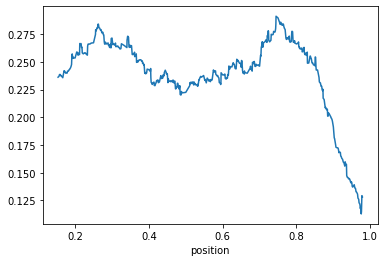

In [23]:
rolling_window = mismatches.groupby('position')['mismatch'].mean().rolling(window=100).mean()

rolling_window.plot();
rolling_window.shape

## Now create bins for positions in verse line

In [13]:
bins = 10 # how many bins?

edges = np.linspace(mismatches.position.min(), mismatches.position.max(), bins+1).astype(float).round(2)

labels = [f'({edges[i]}, {edges[i+1]}]' for i in range(bins)]
mismatches['position_binned'] = pd.cut(mismatches.position, bins=bins, labels=labels)
mismatches['combo'] = mismatches["ms1"]+'-'+mismatches["ms2"]

mismatches

,ms1,ms2,position,mismatch,position_binned,combo
0,A,B,0.000000,0,"(0.0, 0.1]",A-B
1,A,B,0.037037,0,"(0.0, 0.1]",A-B
2,A,B,0.074074,0,"(0.0, 0.1]",A-B
3,A,B,0.111111,0,"(0.1, 0.2]",A-B
4,A,B,0.148148,0,"(0.1, 0.2]",A-B
...,...,...,...,...,...,...
77946,B,C,0.864865,0,"(0.79, 0.89]",B-C
77947,B,C,0.891892,0,"(0.89, 0.99]",B-C
77948,B,C,0.918919,0,"(0.89, 0.99]",B-C
77949,B,C,0.945946,0,"(0.89, 0.99]",B-C


In [14]:
df_binned = mismatches.groupby(['position_binned', 'combo'])['mismatch'].sum().reset_index()
df_binned

,position_binned,combo,mismatch
0,"(0.0, 0.1]",A-B,720
1,"(0.0, 0.1]",A-C,873
2,"(0.0, 0.1]",B-C,733
3,"(0.1, 0.2]",A-B,583
4,"(0.1, 0.2]",A-C,745
5,"(0.1, 0.2]",B-C,667
6,"(0.2, 0.3]",A-B,555
7,"(0.2, 0.3]",A-C,729
8,"(0.2, 0.3]",B-C,674
9,"(0.3, 0.39]",A-B,607


In [15]:
import seaborn as sns
from matplotlib import pyplot as plt

result_binned = df_binned.pivot(index='combo', columns='position_binned', values='mismatch')
fig, ax = plt.subplots(figsize=(16,10)

sns.heatmap(result_binned, fmt="g", cmap='viridis', linewidths=.5) #annot=True
plt.show()

SyntaxError: invalid syntax (<ipython-input-15-872d62d44a01>, line 7)